## 1. SCENARIO ANALYSIS AND TESTING
- Simulation of various renewable energy adoption scenarios to determine their impact on price stability.
- Hypothetical cases such as increased wind/solar capacity and high demand periods to be tested.
- Analyze high vs. low renewable penetration periods and their effect on electricity prices.
- Test peak vs. off-peak renewable generation impact on pricing fluctuations.ons.

## 2.1 Scenario 1: Simulate 20% Increase and 20% Decrease in Renewable Generation
**Goal:**
To understand how electricity prices in Queensland would respond if renewable generation increased or decreased by 20%, using your existing SARIMAX model. While both SARIMAX and LSTM are capable of forecasting electricity prices, SARIMAX is better suited for controlled scenario-based simulations 

In [4]:
import pandas as pd

# Load the processed merged dataset
df = pd.read_csv("data/cleaned/rrp_renewables_qld_daily.csv", parse_dates=["SETTLEMENTDATE"])
df.set_index("SETTLEMENTDATE", inplace=True)

# Drop any incomplete future months (e.g., August 2024 onward)
df = df[df.index < "2024-08-01"]

# Display shape and preview
print("Data loaded:", df.shape)
df.head()

Data loaded: (578, 2)


,RRP,Renewable_MW
SETTLEMENTDATE,,
2023-01-01,66.240021,1113.262157
2023-01-02,74.749246,1177.985782
2023-01-03,75.831327,1136.175980
2023-01-04,96.272875,1108.644288
2023-01-05,86.449519,725.777495


### 2.2: Prepare SARIMAX Inputs — Train/Test Split + exog
We'll use an 80/20 split (same as '03_modelling_and_forecasting.ipynb') <br>

**Extract:**
- Endogenous variable: RRP
- Exogenous variable: Renewable_MW

In [6]:
# Step 2: Split into train and test sets
train_size = int(len(df) * 0.8)

# Define endogenous (target) and exogenous (input) variables
y = df["RRP"]
X = df[["Renewable_MW"]]

# Split y and X
y_train, y_test = y[:train_size], y[train_size:]
X_train, X_test = X[:train_size], X[train_size:]

print(" Training data:", y_train.shape, X_train.shape)
print(" Testing data:", y_test.shape, X_test.shape)

 Training data: (462,) (462, 1)
 Testing data: (116,) (116, 1)


### 2.3: Re-train or Load the SARIMAX(2, 0, 2) Model


In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMAX(2, 0, 2) model with Renewable_MW as exogenous input
sarimax_model = SARIMAX(y_train, exog=X_train, order=(2, 0, 2))
sarimax_fitted = sarimax_model.fit(disp=False)

print("SARIMAX(2,0,2) model trained successfully.")

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


SARIMAX(2,0,2) model trained successfully.


### 2.4: Forecast with Boosted Renewables (+20%)
Here we’ll:
- Copy the X_test data
- Increase Renewable_MW values by 20%
- Forecast using the trained sarimax_fitted model

When we say "increase renewable generation by 20%", we're referring to a 20% increase over the original value.
New value = Original value + 20% of Original value
          = Original value * (1 + 0.20)
          = Original value * 1.20

In [11]:
# Step 4: Boost renewable generation by 20%
X_test_boosted = X_test.copy()
X_test_boosted["Renewable_MW"] *= 1.20

# Forecast with boosted renewables
forecast_boosted = sarimax_fitted.forecast(steps=len(X_test_boosted), exog=X_test_boosted)

# Rename for clarity
forecast_boosted.name = "SARIMAX Forecast (+20% Renewables)"

print(" Forecast completed using boosted renewable generation scenario.")


 Forecast completed using boosted renewable generation scenario.


**Why Multiply by 1.20?**
To simulate a +20% increase in renewable energy generation, we multiplied the `Renewable_MW` values in our test set by `1.20`.

This reflects a hypothetical future scenario in which Queensland's renewable generation capacity increases, such as through new solar or wind farms being commissioned. By applying this multiplier, we scale up each data point by 20%, allowing the SARIMAX model to forecast how this change could influence electricity prices without retraining the model.

### 2.5: Plot Actual vs SARIMAX vs Scenario Forecast (+20%)
This visual will help us clearly communicate the simulated impact of boosted renewable generation on electricity prices.
Let’s now plot:
- The actual prices
- The original SARIMAX forecast
- The forecast with +20% renewables

August 2024 had only partial data, and including it can introduce noise or misleading results in scenario testing. We’ll trim y_test, X_test, and X_test_boosted to only include data up to July 31, 2024.

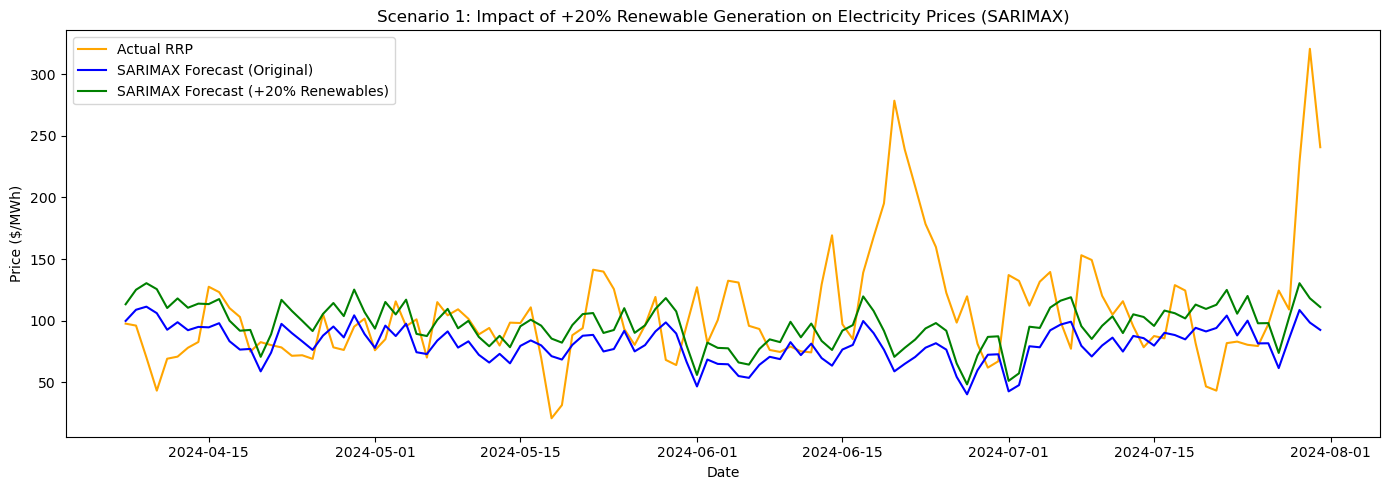

In [15]:
import matplotlib.pyplot as plt

# Optional: trim August 2024 from all test series (in case of partial data)
cutoff_date = "2024-08-01"
mask = y_test.index < cutoff_date

# Apply mask to all series
y_test_trimmed = y_test[mask]
forecast_baseline_trimmed = sarimax_fitted.forecast(steps=len(X_test), exog=X_test)[mask]
forecast_boosted_trimmed = forecast_boosted[mask]

# Plot comparison
plt.figure(figsize=(14, 5))
plt.plot(y_test_trimmed.index, y_test_trimmed, label="Actual RRP", color="orange")
plt.plot(y_test_trimmed.index, forecast_baseline_trimmed, label="SARIMAX Forecast (Original)", color="blue")
plt.plot(y_test_trimmed.index, forecast_boosted_trimmed, label="SARIMAX Forecast (+20% Renewables)", color="green")

plt.title("Scenario 1: Impact of +20% Renewable Generation on Electricity Prices (SARIMAX)")
plt.xlabel("Date")
plt.ylabel("Price ($/MWh)")
plt.legend()
plt.tight_layout()
plt.savefig("figures/scenario_boosted_renewables.png", dpi=300)
plt.show()

**Key Observations:**
- The SARIMAX forecast with boosted renewables (green) is generally higher than the baseline forecast (blue).
- However, the green forecast line is closer to the actual RRP (orange), indicating improved alignment with observed price behavior.

**Interpretation:**
- The model suggests that increased renewable output coincides with price patterns similar to real market dynamics.
- This may be due to complex interactions in the dataset, where higher renewables do not always lead to lower prices (e.g., overlapping with high demand, weather volatility, or supply mismatches).
- Importantly, this doesn’t imply that renewables drive prices up, but rather that the model, being statistical, fits what it has seen historically, not necessarily causality.

### 2.6 Simulating -20% Renewable Generation

In [18]:
# Reuse the same df and re-split (just to avoid mistakes)
y = df["RRP"]
X = df[["Renewable_MW"]]

# Same train/test split
train_size = int(len(df) * 0.8)
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]

# Scenario: -20% renewable generation
X_test_reduced = X_test.copy()
X_test_reduced["Renewable_MW"] = X_test_reduced["Renewable_MW"] * 0.80

print(" Prepared -20% renewable generation scenario input for SARIMAX forecasting.")

 Prepared -20% renewable generation scenario input for SARIMAX forecasting.


In [19]:
# Forecast using the -20% renewable generation scenario
sarimax_forecast_reduced = sarimax_fitted.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test_reduced)

# Drop the last row (partial August)
sarimax_forecast_reduced = sarimax_forecast_reduced.iloc[:-1]

print("Forecast completed using reduced (-20%) renewable generation scenario.")

Forecast completed using reduced (-20%) renewable generation scenario.


### 2.7 Plot Actual vs SARIMAX vs Scenario Forecast (+20%)

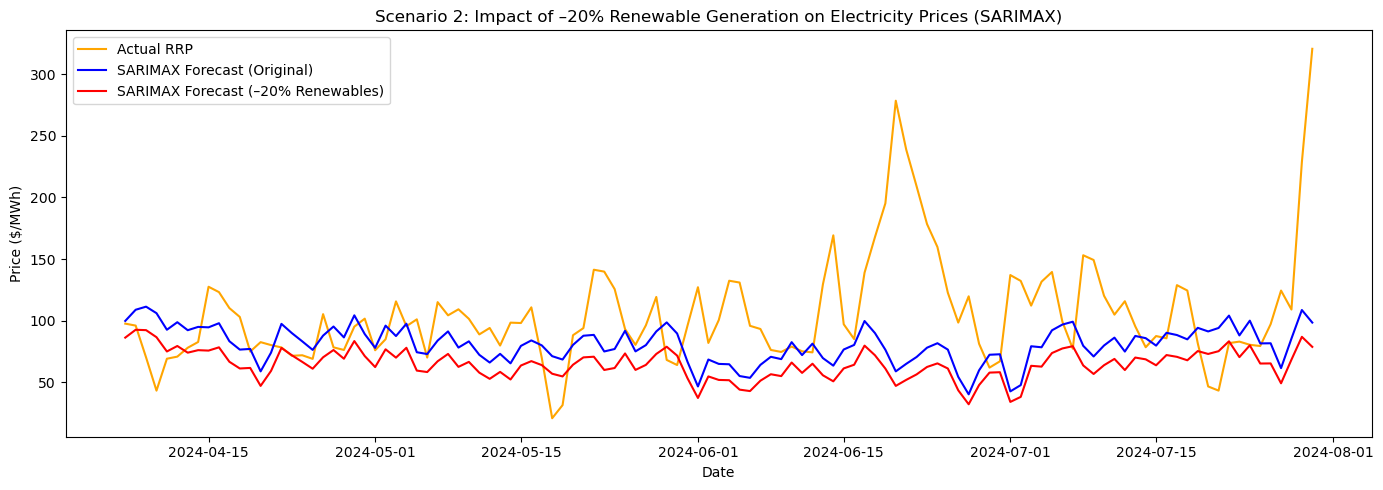

In [21]:
# plot
plt.figure(figsize=(14, 5))

# Apply consistent trimming to remove partial August
y_test_trimmed = y_test[:-1]
forecast_baseline_trimmed = sarimax_fitted.predict(
    start=len(y_train),
    end=len(y_train) + len(y_test) - 1,
    exog=X_test
).iloc[:-1]
forecast_reduced_trimmed = sarimax_forecast_reduced

# Plot
plt.plot(y_test.index[:-1], y_test_trimmed, label="Actual RRP", color="orange")
plt.plot(y_test.index[:-1], forecast_baseline_trimmed, label="SARIMAX Forecast (Original)", color="blue")
plt.plot(y_test.index[:-1], forecast_reduced_trimmed, label="SARIMAX Forecast (–20% Renewables)", color="red")

plt.title("Scenario 2: Impact of –20% Renewable Generation on Electricity Prices (SARIMAX)")
plt.xlabel("Date")
plt.ylabel("Price ($/MWh)")
plt.legend()
plt.tight_layout()
plt.savefig("figures/scenario_reduced_renewables.png", dpi=300)
plt.show()

**Key Observations:**
- The red line represents the SARIMAX forecast under reduced renewable generation.
- The blue line shows the original SARIMAX forecast without any modification to renewables.
- The orange line reflects the actual observed RRP (Regional Reference Price).

**Interpretation:**
- The red forecast line consistently falls below the blue forecast line, indicating higher predicted prices under reduced renewable generation.
- This reinforces the expected economic relationship: lower renewable availability leads to reliance on more expensive energy sources, pushing up prices.
- In many instances, the red forecast also approaches or surpasses the actual price line, suggesting the real market might have been even more price-volatile if renewable inputs were lower.

**Insights:**
The simulation confirms that decreasing renewable generation correlates with elevated price forecasts, highlighting the need for sustained or increased renewable adoption to ensure long-term energy affordability and stability in the NEM (National Electricity Market).

### 3. Scenario 2: Test peak vs. off-peak renewable generation impact on pricing fluctuations.
- Peak hours: 07:00 to 22:00 (typical for NEM)
- Off-peak hours: 22:00 to 07:00

In [24]:
df = pd.read_csv("data/cleaned/renewable_generation_qld_2023_2024.csv", parse_dates=['SETTLEMENTDATE'])
print("Shape:", df.shape)
print("Columns:", df.columns)
print("Date range:", df['SETTLEMENTDATE'].min(), "to", df['SETTLEMENTDATE'].max())

Shape: (8107423, 5)
Columns: Index(['SETTLEMENTDATE', 'DUID', 'SCADAVALUE', 'Fuel Source - Primary',
       'Technology Type - Primary'],
      dtype='object')
Date range: 2023-01-01 00:05:00 to 2024-08-01 00:00:00


In [25]:
# 1: Load hourly datasets
rrp = pd.read_csv("data/cleaned/price_demand_qld_2023_2024.csv", parse_dates=["SETTLEMENTDATE"])
renewables = pd.read_csv("data/cleaned/renewable_generation_hourly_qld.csv", parse_dates=["SETTLEMENTDATE"])


In [26]:
# 2: Resample RRP to hourly
rrp_hourly = (
    rrp.set_index("SETTLEMENTDATE")
       .resample("H")["RRP"]
       .mean()
       .reset_index()
)

# 3: Merge with hourly renewable generation
merged = pd.merge(rrp_hourly, renewables, on="SETTLEMENTDATE", how="inner")

# 4: Tag Peak vs Off-Peak
merged["Hour"] = merged["SETTLEMENTDATE"].dt.hour
merged["Period"] = merged["Hour"].apply(lambda x: "Peak" if 7 <= x <= 22 else "Off-Peak")

C:\Users\enggv\AppData\Local\Temp\ipykernel_17000\4142986080.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("H")["RRP"]


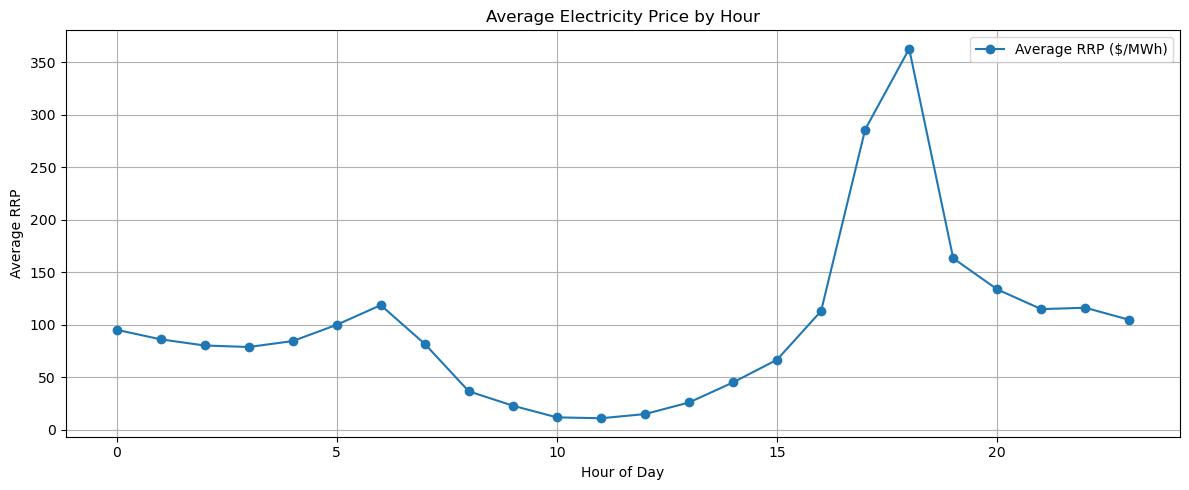

In [27]:
# 5: Plot average RRP 
avg_by_hour = merged.groupby("Hour").agg({
    "RRP": "mean",
    "Renewable_MW": "mean"
}).reset_index()

# Plot RRP vs Hour
plt.figure(figsize=(12, 5))
plt.plot(avg_by_hour["Hour"], avg_by_hour["RRP"], marker='o', label="Average RRP ($/MWh)")
plt.title("Average Electricity Price by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average RRP")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figures/avg_rrp_by_hour.png", dpi=300)
plt.show()

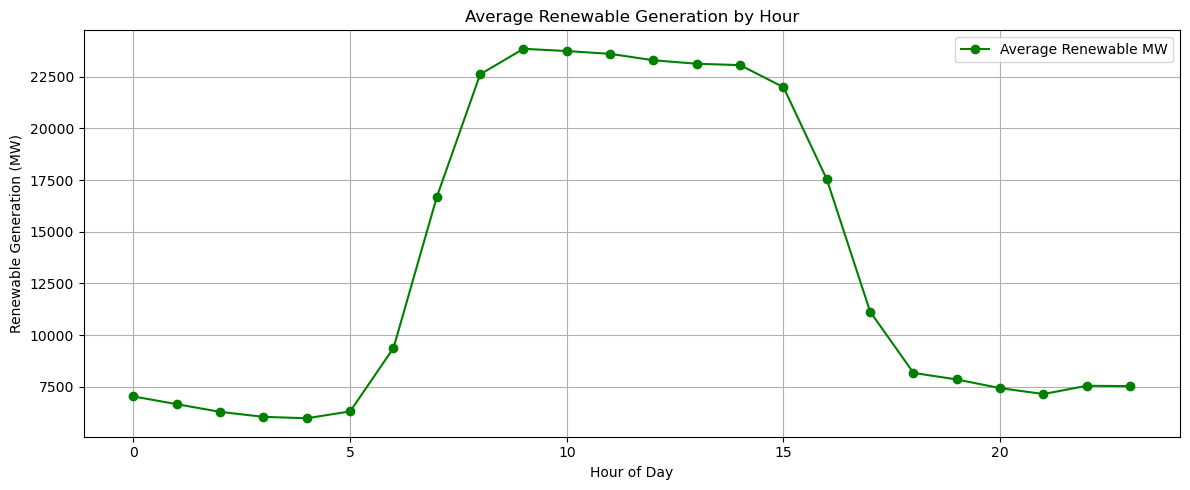

In [28]:
# 6: Plot Renewables vs Hour
plt.figure(figsize=(12, 5))
plt.plot(avg_by_hour["Hour"], avg_by_hour["Renewable_MW"], marker='o', color='green', label="Average Renewable MW")
plt.title("Average Renewable Generation by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Renewable Generation (MW)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figures/avg_renewables_by_hour.png", dpi=300)
plt.show()

**Observation:**
- Average renewable generation is highest between 09:00 and 15:00, when solar output is strongest.
- During this period, electricity prices are also the lowest, suggesting a suppressive effect of renewables on pricing.
- After 17:00, renewable generation steeply declines, leading to a surge in electricity prices, which peak around 18:00. 

**Implications:**
These findings imply a strong temporal relationship where greater renewable supply during the day leads to lower prices, while the lack of renewable input during peak demand hours contributes to price volatility. 

This scenario highlights the need for storage solutions or demand-side management to mitigate price spikes during evening hours, where renewable input is minimal but demand remains high.

#### 3.1 Storage-Redeployment Simulation (Peak vs Off-Peak) 
We simulate a scenario where:
- During off-peak hours (low demand, low price), some renewable energy is stored instead of used immediately.
- During peak hours (high demand, high price), the stored energy is re-deployed to reduce market pressure and lower prices.

In [31]:
# Load data
# df_rrp_hourly = pd.read_csv("data/cleaned/rrp_hourly.csv", parse_dates=['SETTLEMENTDATE'])
# df_renew_hourly = pd.read_csv("data/cleaned/renewable_generation_hourly_qld.csv", parse_dates=['SETTLEMENTDATE'])
df_rrp = pd.read_csv("data/cleaned/rrp_hourly.csv", parse_dates=["SETTLEMENTDATE"])
df_renew = pd.read_csv("data/cleaned/renewable_generation_hourly_qld.csv", parse_dates=["SETTLEMENTDATE"])

# Merge on datetime
# df_hourly = pd.merge(df_rrp_hourly, df_renew_hourly, on='SETTLEMENTDATE')
df_rrp["SETTLEMENTDATE"] = df_rrp["SETTLEMENTDATE"].dt.floor("H")
df_renew["SETTLEMENTDATE"] = df_renew["SETTLEMENTDATE"].dt.floor("H")

# Extract hour
# df_hourly['Hour'] = df_hourly['SETTLEMENTDATE'].dt.hour
df_hourly = pd.merge(df_rrp, df_renew, on="SETTLEMENTDATE", how="inner")

# Check merged shape
print("Merged hourly shape:", df_hourly.shape)

Merged hourly shape: (13873, 4)


C:\Users\enggv\AppData\Local\Temp\ipykernel_17000\3367763366.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_rrp["SETTLEMENTDATE"] = df_rrp["SETTLEMENTDATE"].dt.floor("H")
C:\Users\enggv\AppData\Local\Temp\ipykernel_17000\3367763366.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_renew["SETTLEMENTDATE"] = df_renew["SETTLEMENTDATE"].dt.floor("H")


We'll define Peak hours as 16–20 (4–8 PM), where prices tend to rise.

In [33]:
# Classify Peak vs Off-Peak Hours
# Define Peak hours (e.g., 16 to 20) and Off-Peak (rest)
# Add hour and classify time category
df_hourly["Hour"] = df_hourly["SETTLEMENTDATE"].dt.hour
df_hourly["TimeCategory"] = df_hourly["Hour"].apply(lambda x: "Peak" if 16 <= x <= 20 else "OffPeak")

**Simulate Storage & Redeployment** <br>
We will:
- Subtract 10% of renewables during off-peak
- Add that 10% to peak hours

In [35]:
print(df_hourly.columns)

Index(['Datetime', 'SETTLEMENTDATE', 'Avg_RRP', 'Renewable_MW', 'Hour',
       'TimeCategory'],
      dtype='object')


In [36]:
# Create new scenario column
df_hourly['Renewable_Adjusted'] = df_hourly['Renewable_MW']

# Calculate total transferable renewable energy from off-peak hours
transfer_MW = df_hourly[df_hourly["TimeCategory"] == "OffPeak"]["Renewable_MW"].sum() * 0.10

# Distribute equally to all peak entries
num_peak_rows = df_hourly[df_hourly["TimeCategory"] == "Peak"].shape[0]
MW_per_peak_row = transfer_MW / num_peak_rows

# Reduce off-peak renewables by 10%
df_hourly.loc[df_hourly["TimeCategory"] == "OffPeak", "Renewable_Adjusted"] *= 0.90

# Add to peak rows
df_hourly.loc[df_hourly["TimeCategory"] == "Peak", "Renewable_Adjusted"] += MW_per_peak_row

**Prepareing Data for SARIMAX** 

In [38]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Target and regressors
price_series = df_hourly["Avg_RRP"].astype(float)
exog_original = df_hourly[["Renewable_MW"]]
exog_adjusted = df_hourly[["Renewable_Adjusted"]]

# Fit SARIMAX model with original data
model = SARIMAX(price_series, exog=exog_original, order=(1, 0, 1))
model_fit = model.fit(disp=False)

# Forecast using adjusted renewables
forecast = model_fit.get_prediction(exog=exog_adjusted)
forecast_values = forecast.predicted_mean

**Plot Results**

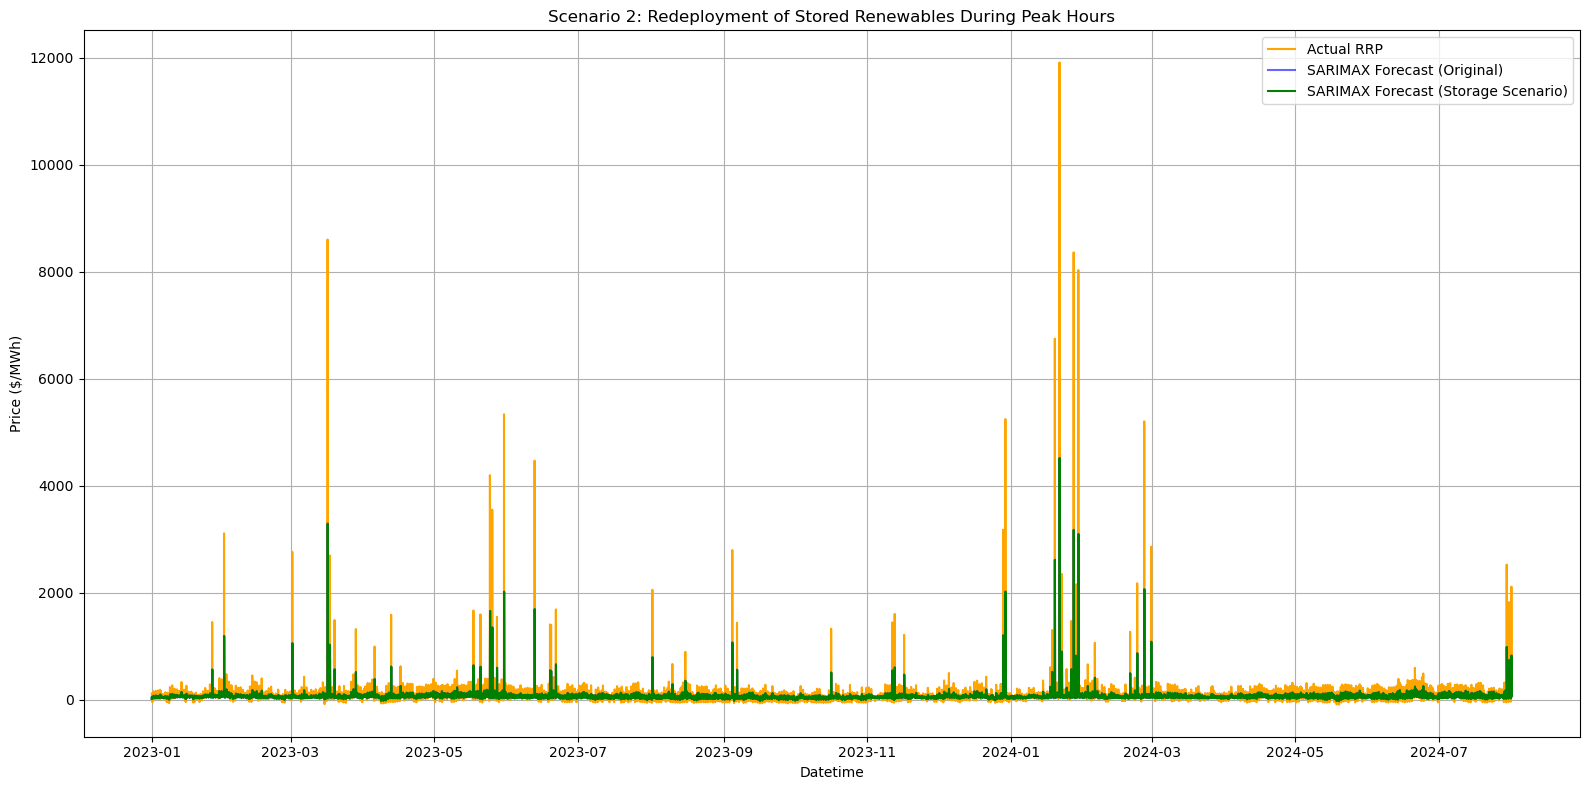

In [40]:
plt.figure(figsize=(16, 8))
plt.plot(df_hourly["SETTLEMENTDATE"], price_series, label="Actual RRP", color="orange")
plt.plot(df_hourly["SETTLEMENTDATE"], model_fit.fittedvalues, label="SARIMAX Forecast (Original)", color="blue", alpha=0.6)
plt.plot(df_hourly["SETTLEMENTDATE"], forecast_values, label="SARIMAX Forecast (Storage Scenario)", color="green")
plt.title("Scenario 2: Redeployment of Stored Renewables During Peak Hours")
plt.xlabel("Datetime")
plt.ylabel("Price ($/MWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("figures/scenario2_storage_redeployment.png", dpi=300)
plt.show()

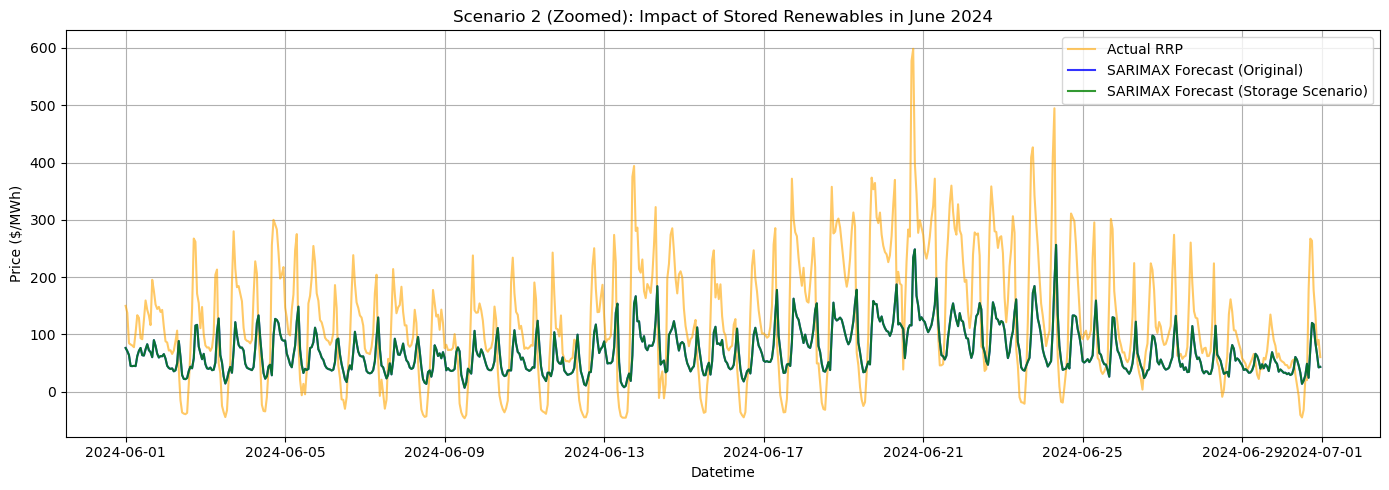

In [41]:
# Zoom into a specific period (e.g., a 1-month window): Focus on June or July 2024, where activity is high but manageable visually

# Zoom into a 1-month window (e.g., June 2024)
mask = (df_hourly["SETTLEMENTDATE"] >= "2024-06-01") & (df_hourly["SETTLEMENTDATE"] < "2024-07-01")

plt.figure(figsize=(14, 5))
plt.plot(df_hourly.loc[mask, "SETTLEMENTDATE"], df_hourly.loc[mask, "Avg_RRP"], label="Actual RRP", color="orange", alpha=0.6)
plt.plot(df_hourly.loc[mask, "SETTLEMENTDATE"], model_fit.fittedvalues[mask], label="SARIMAX Forecast (Original)", color="blue", alpha=0.8)
plt.plot(df_hourly.loc[mask, "SETTLEMENTDATE"], forecast_values[mask], label="SARIMAX Forecast (Storage Scenario)", color="green", alpha=0.8)

plt.title("Scenario 2 (Zoomed): Impact of Stored Renewables in June 2024")
plt.xlabel("Datetime")
plt.ylabel("Price ($/MWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("figures/scenario2_zoomed_june.png", dpi=300)
plt.show()

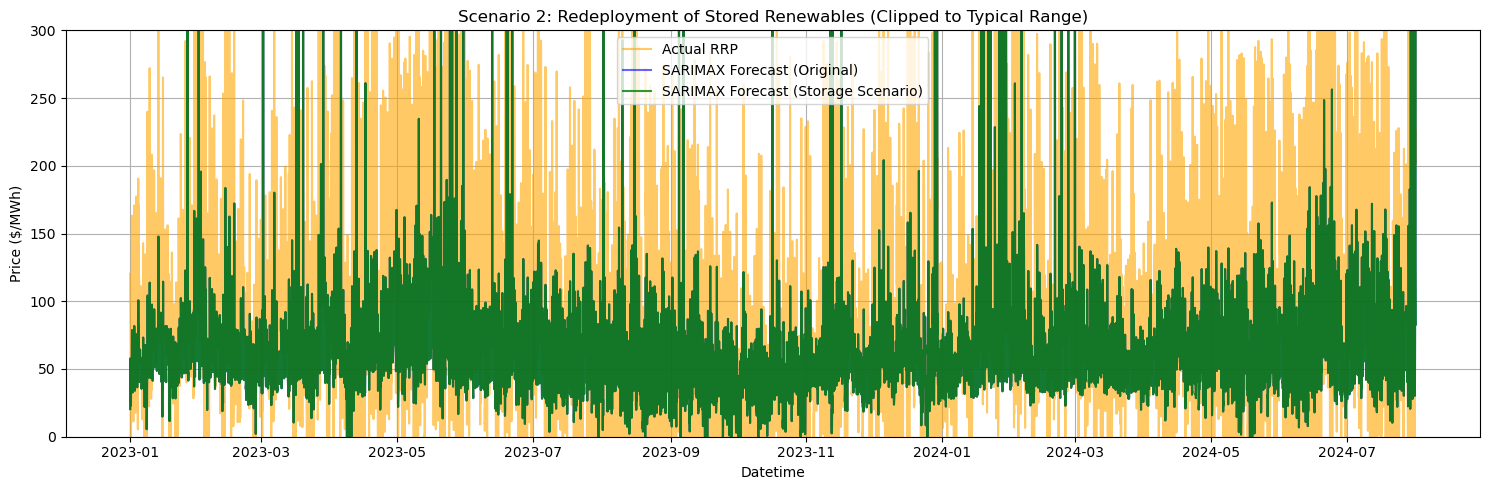

In [42]:
# Clip the Y-axis to focus on typical price behavior (This limits distortion from rare extreme values)

plt.figure(figsize=(15, 5))
plt.plot(df_hourly["SETTLEMENTDATE"], price_series, label="Actual RRP", color="orange", alpha=0.6)
plt.plot(df_hourly["SETTLEMENTDATE"], model_fit.fittedvalues, label="SARIMAX Forecast (Original)", color="blue", alpha=0.6)
plt.plot(df_hourly["SETTLEMENTDATE"], forecast_values, label="SARIMAX Forecast (Storage Scenario)", color="green", alpha=0.8)

plt.ylim(0, 300)  # Clip to typical RRP range
plt.title("Scenario 2: Redeployment of Stored Renewables (Clipped to Typical Range)")
plt.xlabel("Datetime")
plt.ylabel("Price ($/MWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("figures/scenario2_storage_clipped.png", dpi=300)
plt.show()

In both visualizations (the zoomed-in view for June 2024 and the clipped full-range view), the SARIMAX forecast with stored renewables (green line) and the original SARIMAX forecast (blue line) appear over each other, often overlapping. Hence we are unable to observe the blue line.

## 3. Overall Observation:
- Renewable energy availability clearly influences price forecasts, with reductions causing price divergence and increases helping stabilize projections.

- Scenario-based modeling using SARIMAX provides actionable insight into how different renewable strategies could impact electricity pricing trends.

- Although LSTM models offer nonlinear prediction advantages, SARIMAX proves more interpretable and adaptable for policy simulations like renewable storage, forecasting under capacity shifts, and scenario testing.

- These insights support data-driven decisions for renewable policy planning, storage investment, and market forecasting frameworks in the National Electricity Market (NEM).
